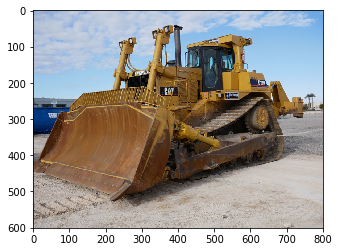

(601, 800, 3)
(800, 3)
[[113 154 206]
 [116 157 209]
 [117 159 209]
 [113 155 205]
 [109 150 204]]


In [36]:
from scipy.misc import imread
import matplotlib.pyplot as plt

img = imread('./data/bulld.jpg')
plt.imshow(img)
plt.show()

print(img.shape)
print(img[0].shape)
print(img[0][:5])

In [40]:
import numpy as np

def assess_output_vol(input_size, fi, s, padd, K):
    """
        Computes the suitable output volume given S, F, P and K
        Assumes a squared filter
    """

    on_h_axis = (input_size[0]-fi + 2*padd[0])/(s) + 1
    assert on_h_axis == int(on_h_axis), "The height axis requires padding : {}".format(on_h_axis)
    on_w_axis = (input_size[1]-fi + 2*padd[1])/(s) + 1
    assert on_w_axis == int(on_w_axis),"The width axis requires padding : {}".format(on_w_axis)
    on_d_axis = K
    #print(f'The dimensions of the output volume are \
    #    {on_h_axis} by {on_w_axis} by {on_d_axis}.')
    return (int(on_h_axis), int(on_w_axis), on_d_axis)

def convolutional_layer1(img, filter_size, stride, padding, K):
    """
        Receives a image (H*W*3)
        The kernel size is filter_size*filter_size*3
        The weights are learned by the CNN where each "slice" is a filter
        The depth of the output map is represented by K

        Returns:
            Activation map applying the filter to the input
    """
    weights = np.random.rand(K, filter_size, filter_size, img.shape[2])
    biases = np.random.rand(K, 1)
    print(f'The weights shape is {weights.shape} and biases shape is {biases.shape}')
    print(weights[0,:,:,:].shape) # filter0 or weight0

    out_dims = assess_output_vol(img.shape, filter_size, stride, padding, K)

    activation_map = np.zeros(out_dims)
    assert activation_map.shape == out_dims

    for d in range(out_dims[2]):
        for i in range(0,img.shape[0],stride):
            for j in range(0,img.shape[1],stride):
                activation_map[int(i/stride),int(j/stride),d] = np.sum(img[i:i+filter_size,j:j+filter_size,:] * weights[d,:,:,:]) + biases[d]
    
    print(f'The output volume shape is {activation_map.shape}\n')

    return activation_map

K = 10 # depth of output map

# Testing for suitable strides and Filter size combinations
assess_output_vol((11,11,3), 5, 2, [0,0], K)
assess_output_vol((img.shape[0]-1,img.shape[1],img.shape[2]), 22, 4, [1,1], K) # removing 1 pixel in H and adding 1 of padding to each side
# Passing the image through a basic convolution layer
#print(img[:,0,:].shape)
adjusted_img = img
adjusted_img = np.delete(adjusted_img,[0,1,2],0)
#adjusted_img[:,0,:] = np.zeros((adjusted_img.shape[0], adjusted_img.shape[2]))
print(adjusted_img.shape)
padd = np.zeros((adjusted_img.shape[0],2,adjusted_img.shape[2]))
print(padd.shape)
adjusted_img = np.concatenate((adjusted_img, padd),axis=1)
print(adjusted_img.shape)

activn_map_conv = convolutional_layer1(adjusted_img, 22, 4, [0,0], K)
#print(activn_map_conv[:2,:2,:])


(598, 800, 3)
(598, 2, 3)
(598, 802, 3)
The weights shape is (10, 22, 22, 3) and biases shape is (10, 1)
(22, 22, 3)


ValueError: operands could not be broadcast together with shapes (22,18,3) (22,22,3) 

In [195]:
def find_volume_pooling(input_size, F, S):
    """
        Given the input size (H,W,D) it calculates 
            the output volume (H',W',D) by the pooling operation
    """
    on_h_axis = (input_size[0] - F)/(S) + 1
    assert on_h_axis == int(on_h_axis), "The height axis requires padding : {}".format(on_h_axis)
    on_w_axis = (input_size[1] - F)/(S) + 1
    assert on_w_axis == int(on_w_axis),"The width axis requires padding : {}".format(on_w_axis)
    on_d_axis = input_size[2] # assuming (H,W,D)

    return (int(on_h_axis), int(on_w_axis), on_d_axis)

def pooling_layer1(input, F, S):
    """
        The basic intuition is very similar to the Convolutional layer
            expect it doesn't require weights or biases
        The goal here is to reduce the is to "compress" the input volume by
            discarding everything other than the maximum over a F * F area
        The most common way to compress is to use a MAX operation over each filter slice

    """
    
    out_dims = find_volume_pooling(input.shape, F, S)
    pooling_out = np.zeros(out_dims)

    for d in range(input.shape[2]):
        for i in range(input.shape[0],S):
            for j in range(input.shape[1],S):
                # Implementing the MAX-Pooling operation
                pooling_out[int(i),int(j),d] = np.max(input[i:i+F,j:j+F,d])
    
    print(f'The output volume shape is {pooling_out.shape}\n')

    return pooling_out


F=2 # filter size by convention
S=2 # stride by convention

# Testing the output volume
find_volume_pooling((224,224,64), F, S)
find_volume_pooling((151+1,186,10), F, S) # It means that it requires zero-padding of 1 in the height component

# adding zero padding to height - it is irrelevant to which part
input_pooling = activn_map_conv
print(input_pooling.shape)
print(input_pooling[1,:,0]) # TODO bug on convolution ???
t = np.zeros((1,input_pooling.shape[1],10))
input_pooling = np.concatenate((activn_map_conv, t),axis=0)
print(input_pooling.shape)

# TODO test properly
out_pooling = pooling_layer1(input_pooling, F, S)

(151, 196, 10)
[1340855.917742   1344391.083028   1349052.26135965 1352099.79734656
 1353331.67289644 1354086.43845159 1352980.06513627 1348378.61831897
 1344636.21073665 1343192.80699971 1347739.95835253 1355283.47233562
 1366586.43795343 1382197.26834377 1396575.98258795 1406192.73616348
 1412916.93639841 1421849.87770759 1427225.45896574 1432473.19454806
 1439473.82127531 1445069.995418   1444079.29741289 1440523.79782216
 1439043.68547505 1433817.38547282 1426349.11557126 1418305.86089394
 1416230.17467223 1413682.18503373 1413725.5441375  1415102.59074606
 1422806.47755569 1433887.52791656 1444179.96180537 1453652.26321567
 1460161.60182411 1466824.46915952 1469500.8912089  1472292.38780372
 1476211.71354387 1482085.18886909 1489762.67159564 1496516.95332584
 1500864.3623877  1502688.07770074 1501605.2687068  1498169.41673736
 1493809.82755593       0.               0.               0.
       0.               0.               0.               0.
       0.               0.         

In [ ]:
# TODO 
# FIX bug in convolution ?
# Implement fully connected layer
# Change the loops to vectorized operations
# Conversion from fully connected layer to CONV layer and vice-versa
# Explore doing a small autograd engine where both pooling and convolutional layers are applied sequentially
#